# 相関係数を算出

## 課題点

- 名義尺度の変数の扱い

## 解決策

- SalePriceの平均値を用いて、順序変数に変換しピアソンの積率相関で比較

In [1]:
import pandas as pd
import numpy as np

# dataのロード
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

# 説明変数と目的に変数に分ける
train_id = train_data["Id"]
test_id = test_data["Id"]

train_data.drop("Id", axis=1, inplace=True)
test_data.drop("Id", axis=1, inplace=True)

# 名義尺度と順序（連続）変数を分割する

unnominal_scales =  [col for col in train_data.columns if train_data.dtypes[col] != 'object']
nominal_scales = [col for col in train_data.columns if train_data.dtypes[col] == 'object']

## SalePriceが小さい順に順位を割り充てる
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['sp_mean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('sp_mean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for key, val in ordering.items():
        frame.loc[frame[feature] == key, feature+'_encode'] = val

# 名義尺度に対して順序尺度にエンコードする
for nominal_scale in nominal_scales:
    encode(train_data, nominal_scale) # train_dataに_encode列が追加される
    
# 順序尺度（連続尺度）だけ取り出して、相関係数を導く

corr_mat = train_data.corr()
N = 2 # 最も高い相関関係の特徴量を算出（自身抜かす）
cols = corr_mat.nlargest(N, 'SalePrice')['SalePrice'].index
cols = [val for val in cols if val != "SalePrice"]

print("----------answer start-----------")
print("most correleted feature is {}".format(cols[0]))
print("----------answer end-----------")

----------answer start-----------
most correleted feature is OverallQual
----------answer end-----------


## 追記

- 本来は連続尺度と順序尺度を同じ相関係数の計算方法で求めるべきではない（今回は、一律でピアソンの積率相関係数を用いた）
    - 連続尺度では、0と1の差である1という数値には意味があるが、順序尺度では無意味。よって本来は導出が異なる相関係数を求めるべき。
    - ただ、別の計算で算出された値を比較することはできないので、厳密にやるとこの問題はとても複雑。

# モデリング

1. 前処理
2. 特徴量作成
3. モデリング
4. 精度評価

In [2]:
# train_dataのカラムを元に戻す
remove_columns = [col+"_encode" for col in nominal_scales]
train_data = train_data.drop(remove_columns, axis=1)

In [3]:
# NaNの削除処理

all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
train_size = train_data.shape[0]
test_size = test_data.shape[0]
all_data = all_data.drop(["SalePrice"], axis=1)

In [4]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data)

              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageFinish       5.447071
GarageYrBlt        5.447071
GarageQual         5.447071
GarageCond         5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517
BsmtHalfBath       0.068517
Utilities          0.068517
Functional         0.068517
Exterior2nd        0.034258
Exterior1st        0.034258
SaleType           0.034258
BsmtFinSF1         0.034258
BsmtFinSF2         0.034258
BsmtUnfSF          0.034258
Electrical         0.034258
KitchenQual        0.034258
GarageCars         0.034258
GarageArea         0.034258
TotalBsmtSF        0.034258


In [5]:
# testデータにNanが含まれるのはまずいので全部処理する

# カテゴリカル変数はとりあえずNone埋め
for col in nominal_scales:
    all_data[col] = all_data[col].fillna("None")

# 近隣の中央値埋め
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# 0埋め
for col in  [i for i in unnominal_scales if i not in  ["LotFrontage", "SalePrice"]]:
    all_data[col] = all_data[col].fillna(0)

# 特徴量を正規化
for col in [i for i in unnominal_scales if i != "SalePrice"]:
    all_data[col] = all_data[col].apply(lambda x: (x-min(all_data[col]))/ (max(all_data[col]) - min(all_data[col])))

In [6]:
from sklearn.ensemble import IsolationForest
# 外れ値処理

# まずはtrainデータに分割
train_data = pd.concat((all_data[:train_size], train_data["SalePrice"]),axis=1)
test_data = all_data[test_size:].reset_index(drop=True)

# 決定木ベースで外れ値処理を行う（高次元のため）
clf = IsolationForest(random_state=1234,n_estimators=500, contamination=0.005)
clf.fit(train_data[unnominal_scales])

/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.005,
        max_features=1.0, max_samples='auto', n_estimators=500,
        n_jobs=None, random_state=1234, verbose=0)

In [7]:
out_result = pd.DataFrame(clf.predict(train_data[unnominal_scales]))
out_result.columns = ['out_flag']
print("外れ値個数は{}".format(sum(out_result["out_flag"] == -1)))

# out_flagが1のものだけ取り出す。
train_data = train_data[train_data.index.isin(list(out_result[out_result["out_flag"] == 1].index))].reset_index(drop=True)

/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


外れ値個数は8


In [8]:
# 2. 特徴量選択

## 第1問で相関係数の高いtop20を用いる

cols_feature = corr_mat.nlargest(21, 'SalePrice')['SalePrice'].index
features = [col.replace("_encode", "") if "_encode" in col else col for col in cols_feature]
new_train = train_data[features]

## 目的変数の正規化
import seaborn as sns
from scipy.stats import norm, skew 

sns.distplot(new_train['SalePrice'] , fit=norm)



/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


- 右に裾野が広いデータになっている。
- log変換でより正規分布に近づける

/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


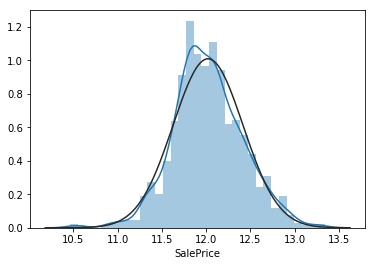

In [9]:
new_train["SalePrice"] = np.log1p(new_train["SalePrice"])
sns.distplot(new_train["SalePrice"], fit=norm)

In [10]:
# 目的変数を平均0,分散1に標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
new_train["SalePrice_sc"] = sc.fit_transform(np.array(new_train["SalePrice"]).reshape(-1,1))


/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# モデリング

- deep learningによる回帰モデルを採用

- カテゴリー変数が多いことから単純に変数を作成すると変数膨大のため、特徴量作成や潜在的変数はdeepに任せる

- カテゴリー変数部分は embedding処理をほどこしてから、連続変数とマージするアーキとする

In [11]:
# モデリング

import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

category_col = [i for i in new_train.columns if new_train[i].dtypes == "object"]
embed_size = {"Neighborhood":10, "ExterQual":3, "KitchenQual":4, "BsmtQual":4,"PoolQC":2, "Alley":2, "GarageFinish":3, "Foundation":5}
feature_size = {}
feature_dic = {}

for col in category_col:
    feature_size[col] = len(new_train[col].value_counts())
    feature_dic[col] = {}
    idx = 0
    for val in new_train[col].unique():
        feature_dic[col][val] = idx
        idx += 1

class HousePredictionModel(chainer.Chain):
    
    def __init__(self, out_size=1):
        super(HousePredictionModel, self).__init__()
        with self.init_scope():
            for col in category_col:
                setattr(self, "embed_"+col, L.EmbedID(feature_size[col], embed_size[col], ignore_label=-1))
            self.l10 = L.Linear(None, 25) # カテゴリカル変数用
            self.l11 = L.Linear(None, 25) # 連続変数用 
            self.l2 = L.Linear(None, 10)
            self.l3 = L.Linear(None, out_size)
    
    def __call__(self, x1, x2, x3, x4,x5,x6,x7,x8, x9, y=None):
        val_list = [x1,x2,x3,x4,x5,x6,x7,x8]
        h1 = F.leaky_relu(self.l11(x9)) # ここが連続変数
        embed_h = getattr(self, "embed_"+category_col[0])(val_list[0])
        for col,val in zip(category_col[1:], val_list[1:]):
            embed_h = F.concat([embed_h, getattr(self, "embed_"+col)(val)], axis=1)
        embed_h = F.leaky_relu(self.l10(embed_h))
        h1 = F.concat([h1,embed_h], axis=1)
        h2 = F.leaky_relu(self.l2(h1))
        h3 = self.l3(h2)
        if  y is None:
            return h3
        loss = F.mean_squared_error(h3,y)
        report({'loss': loss}, self)
        return loss


/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [12]:
# カテゴリカル変数をIDに変換する処理

def make_dataset(dataset):
    for col in [i for i in new_train.columns if new_train[i].dtypes == "object"]:
        dataset[col] = dataset[col].apply(lambda x: feature_dic[col].get(x) if x in feature_dic[col].keys() else -1)
    

In [13]:
# 学習実施
train_rate = 0.9
train_size = int(len(new_train) * train_rate)

train = new_train.sample(frac=1).reset_index(drop=True)[:train_size]
test = new_train[train_size:]
train_y = np.array(train["SalePrice_sc"], dtype=np.float32).reshape(len(train), 1)
train_x9 = np.array(train[[i for i in new_train.columns if new_train[i].dtypes != "object" and i not in ["SalePrice", "SalePrice_sc"]]]
                    , dtype=np.float32)
make_dataset(train)


test_y = np.array(test["SalePrice_sc"], dtype=np.float32).reshape(len(test), 1)
test_x9 = np.array(test[[i for i in new_train.columns if new_train[i].dtypes != "object" and i not in ["SalePrice", "SalePrice_sc"]]]
                    , dtype=np.float32)
make_dataset(test)

train_dataset = chainer.datasets.TupleDataset(
    np.array(train[category_col[0]]),
    np.array(train[category_col[1]]),
    np.array(train[category_col[2]]),
    np.array(train[category_col[3]]),
    np.array(train[category_col[4]]),
    np.array(train[category_col[5]]),
    np.array(train[category_col[6]]),
    np.array(train[category_col[7]]),
    train_x9,
    train_y
)

test_dataset = chainer.datasets.TupleDataset(
    np.array(test[category_col[0]]),
    np.array(test[category_col[1]]),
    np.array(test[category_col[2]]),
    np.array(test[category_col[3]]),
    np.array(test[category_col[4]]),
    np.array(test[category_col[5]]),
    np.array(test[category_col[6]]),
    np.array(test[category_col[7]]),
    test_x9,
    test_y
)

minibatch_size = 100
train_iter = iterators.SerialIterator(train_dataset, minibatch_size)
test_iter = iterators.SerialIterator(test_dataset, minibatch_size, False, False)

model = HousePredictionModel()
optimizer = optimizers.Adam()
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (1000, 'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.snapshot(filename="model_snapshot"), trigger=(1000, 'epoch'))
trainer.extend(extensions.LogReport(trigger=(10, 'epoch')))
trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
trainer.run()

/Users/01014554/.pyenv/versions/3.6.5/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


epoch       main/loss   validation/main/loss  elapsed_time
10          0.442748    0.404682              1.36786       
20          0.163428    0.184205              3.04627       
30          0.127303    0.143559              4.44943       
40          0.115293    0.132145              5.8534        
50          0.108022    0.121654              7.6544        
60          0.102839    0.118277              9.01816       
70          0.0996258   0.113746              10.5144       
80          0.0968955   0.11037               11.8116       
90          0.0939554   0.108473              13.1048       
100         0.0923746   0.106608              14.4429       
110         0.0898719   0.105115              15.8605       
120         0.0877943   0.104904              17.2461       
130         0.0846299   0.101595              18.6722       
140         0.0835526   0.101791              20.0529       
150         0.0812558   0.0984524             21.3886       
160         0.0798122   0.

# 学習考察

- 過学習を防ぐ方法もあるが、今回validation_lossも下がっていることから、過学習はしていなさそうなのでこのまま

- 600epoch程度でlossの減少率が下がっていることから、今回のモデルではこの辺が限界

In [14]:
# テストデータに関する予測

test_predict_data = test_data[[i for i in features if i != "SalePrice"]].reset_index(drop=True)
make_dataset(test_predict_data)
test_predict_x9 = np.array(test_predict_data[[i for i in new_train.columns if new_train[i].dtypes != "object" and i not in ["SalePrice", "SalePrice_sc"]]]
                    , dtype=np.float32)
test_evaluator = extensions.Evaluator(test_iter, model)
result = model(np.array(test_predict_data[category_col[0]]),
    np.array(test_predict_data[category_col[1]]),
    np.array(test_predict_data[category_col[2]]),
    np.array(test_predict_data[category_col[3]]),
    np.array(test_predict_data[category_col[4]]),
    np.array(test_predict_data[category_col[5]]),
    np.array(test_predict_data[category_col[6]]),
    np.array(test_predict_data[category_col[7]]),
    test_predict_x9)

# SalePriceを基に戻す
before_sc_result = sc.inverse_transform(result.data)
final_result = np.expm1(before_sc_result)

# final_resultが最終予測数値
test_data["predict_sale_price"] = final_result